In [1]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

from qiskit_ode.dispatch import Array
from qiskit_ode.signals.new_signals import Signal, Constant, PiecewiseConstant, SignalSum, PiecewiseConstantSignalSum

## Vectorized evaluation

Things are now written to explicitly enable vectorized evaluation.

In [2]:
sig1 = Signal(lambda t: t, carrier_freq=0.1)

In [3]:
sig1(np.array([2., 3.]))

array([ 0.61803399, -0.92705098])

If the user specifies a function which is not vectorized, they can specify that it needs to be.

In [4]:
def nonvectorized_func(t):
    if t < 1.:
        return t
    else:
        return 50.

sig2 = Signal(nonvectorized_func, carrier_freq=1.0, vectorize_envelope=True)

In [5]:
sig2(np.array([0.1, 2., -1., 3.]))

array([ 0.0809017, 50.       , -1.       , 50.       ])

Currently it is necessary to pass such a list as an array.

## Plotting

Plot the signal, the envelope, and the complex value.

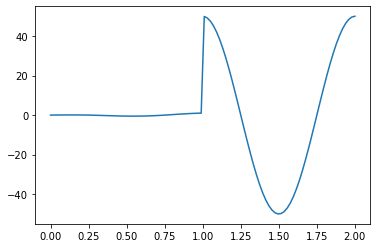

In [6]:
sig2.plot(0, 2, 100)

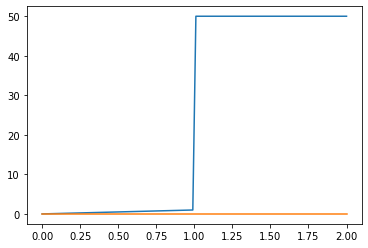

In [7]:
sig2.plot_envelope(0, 2, 100)

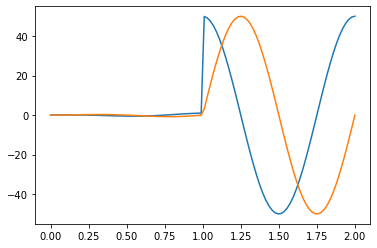

In [8]:
sig2.plot_complex_value(0, 2, 100)

## string rep

In [9]:
str(sig2)

'Signal(carrier_freq=1.0, phase=0.0)'

In [10]:
sig2.name = 'new_name'
str(sig2)

'new_name'

## SignalSum

still need to define summation but want to check vectorized evaluation is working

In [11]:
sig1 = Signal(lambda t: t + t**2 * 1j, carrier_freq=1.)
sig2 = Signal(lambda t: -t, carrier_freq=2.)

In [12]:
sig_sum = SignalSum(sig1, sig2)
str(sig_sum)

'Signal(carrier_freq=1.0, phase=0.0) + Signal(carrier_freq=2.0, phase=0.0)'

In [13]:
t = 0.2
print(sig_sum(t))
print(sig1(t) + sig2(t))

0.18556453709817283
0.18556453709817283


In [14]:
t = np.array([1.1, 0.2])
print(sig_sum(t))
print(sig1(t) + sig2(t))

[-0.16122016  0.18556454]
[-0.16122016  0.18556454]


In [15]:
t = np.array([[1.1, 0.2], [4.6, 4.7]])
print(sig_sum(t))
print(sig1(t) + sig2(t))

[[-0.16122016  0.18556454]
 [ 7.29457959 23.35883844]]
[[-0.16122016  0.18556454]
 [ 7.29457959 23.35883844]]


## collapsing

merge all terms into a single Signal

In [16]:
sig1 = Signal(1., carrier_freq=2.)
sig2 = Signal(2., carrier_freq=3.)
sig_sum = SignalSum(sig1, sig2)

In [17]:
sig_sum(1.2)

-2.4270509831248432

In [18]:
sig1(1.2) + sig2(1.2)

-2.4270509831248432

In [19]:
# returns a single signal with frequencies averaged
sig_merged = sig_sum.collapse()

In [20]:
sig_merged(1.2)

-2.427050983124843

In [21]:
sig_merged.carrier_freq

Array(2.5, backend='numpy')

## Constant

In [22]:
const = Constant(3.)

In [23]:
const.envelope(np.array([1., 1.]))

Array([3.+0.j, 3.+0.j], backend='numpy')

In [24]:
const(np.array([1., 1.]))

Array([3., 3.], backend='numpy')

## PiecewiseConstant

In [25]:
sig = PiecewiseConstant(dt=1., samples=np.array([1., 2., 3.]), carrier_freq=0.5)

In [26]:
sig(np.array([2.1, 1.1]))

Array([ 2.85316955, -1.90211303], backend='numpy')

In [27]:
not isinstance(sig, SignalSum)

True

In [28]:
test = Array(1.)

In [29]:
test.ndim

0

## Signal addition

In [30]:
sig1 = Signal(1., carrier_freq=2.)
sig2 = Signal(2., carrier_freq=3.)
sig3 = PiecewiseConstant(dt=0.5, samples=np.array([1., 2., 3.]))
sig_sum = sig1 + sig2

In [31]:
sig_sum2 = 2. + sig1
sig_sum3 = sig1 + 2.
sig_sum4 = sig3 + sig1

In [32]:
str(sig_sum2)

'Signal(carrier_freq=2.0, phase=0.0) + Constant(2.0)'

In [33]:
str(sig_sum3)

'Signal(carrier_freq=2.0, phase=0.0) + Constant(2.0)'

In [34]:
str(sig_sum4)

'PiecewiseConstant(dt=0.5, carrier_freq=0.0, phase=0.0) + Signal(carrier_freq=2.0, phase=0.0)'

In [35]:
sig3.name = 5.

## Multiplication

In [36]:
sig_prod = sig1 * sig2

In [37]:
print(sig1.carrier_freq)
print(sig2.carrier_freq)

2.0
3.0


In [38]:
sig_prod.carrier_freq

Array([ 5., -1.], backend='numpy')

In [39]:
sig_prod(1.1) - (sig1(1.1) * sig2(1.1))

-1.609823385706477e-15

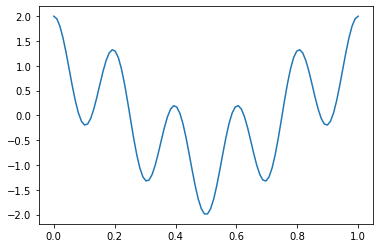

In [40]:
sig_prod.plot(0., 1., 100)

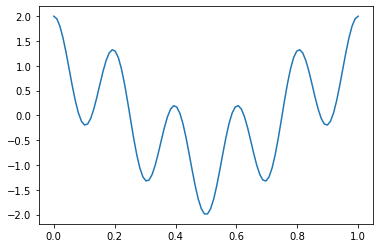

In [41]:
t_vals = np.linspace(0., 1., 100)
y_vals = sig1(t_vals) * sig2(t_vals)
plt.plot(t_vals, y_vals)

## special multiplication rules

Constants have their internal values multiplied

In [42]:
const_prod = Constant(3.) * Constant(2.)
str(const_prod)

'Constant(6.0)'

PiecewiseConstants with compatible parameters (start time, dt, and number of samples) are implemented via array multiplication. (We can extend these rules to pad signals and what not.)

In [43]:
pwc_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.]), carrier_freq=1.) *
            PiecewiseConstant(dt=0.1, samples=np.array([4.,5.,6.]), carrier_freq=2.))
str(pwc_prod)

'PiecewiseConstant(dt=0.1, carrier_freq=3.0, phase=0.0) + PiecewiseConstant(dt=0.1, carrier_freq=-1.0, phase=0.0)'

If one of the piecewise constants has zero frequency, then it returns only a single piecewise constant.

In [44]:
pwc_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.])) *
            PiecewiseConstant(dt=0.1, samples=np.array([4.,5.,6.]), carrier_freq=2.))
print(str(pwc_prod))
pwc_prod(0.02) - (1. * 4. * np.cos(2 * np.pi * 2. * 0.02))

PiecewiseConstant(dt=0.1, carrier_freq=2.0, phase=0.0) + PiecewiseConstant(dt=0.1, carrier_freq=-2.0, phase=0.0)


0.0

For pairs for which special handling doesn't apply generic Signals are returned.

In [45]:
general_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.]), carrier_freq=1.) *
               Signal(envelope=lambda t: t, carrier_freq=2.))
print(str(general_prod))
general_prod(0.02) - (np.cos(2 * np.pi * 0.02) * 0.02 * np.cos(2 * np.pi * 2. * 0.02))

Signal(carrier_freq=3.0, phase=0.0) + Signal(carrier_freq=-1.0, phase=0.0)


0.0

## PiecewiseConstantSignalSum

In [46]:
samples = np.array([[1., 2., 3.], [4, 5., 6.], [7., 8., 9.]])
freqs = np.array([1., 2., 3.])
dt = 1.

sig_sum = PiecewiseConstantSignalSum(dt=dt, samples=samples, carrier_freqs=freqs)

In [47]:
sig_sum(2.1)

1.4999999999999893

In [48]:
sig_sum[0](2.1) + sig_sum[1](2.1) + sig_sum[2](2.1)

1.4999999999999893

In [49]:
sig_sum(np.array([1., 2.1, 2.9]))

Array([15. ,  1.5,  1.5], backend='numpy')

## IQ Mixer via signal algebra

In [50]:
# define some envelope function
def env(t):
    return t * (1 - t)

w_d = 2.
w_lo = 1.9
w_if = 0.1

I = Signal(env, carrier_freq=w_if, name='I') # envelope times cosine at w_if
Q = Signal(env, carrier_freq=w_if, phase=-np.pi/2, name='Q') # envelope times sine at w_if

slo_I = Signal(1., carrier_freq=w_lo, name='slo_I') # local oscillator for I
slo_Q = Signal(1., carrier_freq=w_lo, phase=-np.pi/2, name='slo_Q') # local oscillator for Q

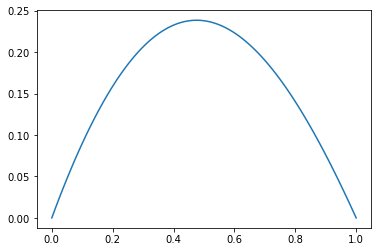

In [51]:
I.plot(0, 1, 100)

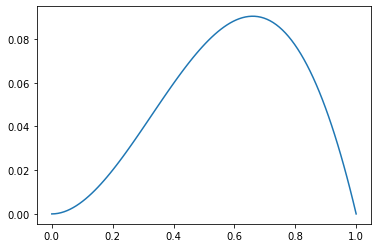

In [52]:
Q.plot(0, 1, 100)

In [54]:
IQ_output = ((I * slo_I) - (Q * slo_Q))
str(IQ_output)

'Signal(carrier_freq=2.0, phase=0.0) + Signal(carrier_freq=-1.7999999999999998, phase=0.0) + Signal(carrier_freq=2.0, phase=-3.141592653589793) + Signal(carrier_freq=-1.7999999999999998, phase=0.0)'

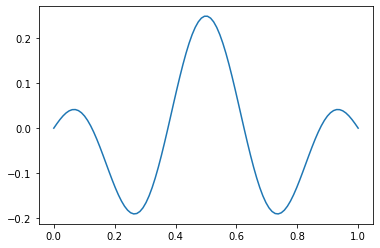

In [55]:
IQ_output.plot(0, 1, 100)

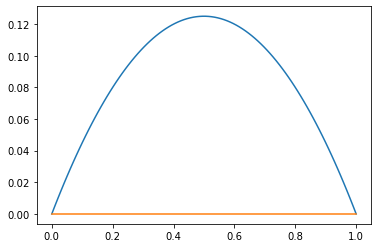

In [56]:
IQ_output[0].plot_envelope(0, 1, 100)

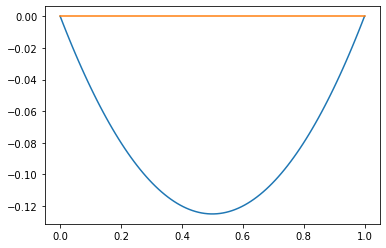

In [59]:
IQ_output[3].plot_envelope(0, 1, 100)

## Convolution

We need to work through the mathematics of convolution as they apply to `Signal`s. First, the general continuous definition, for two functions $f, g : \mathbb{R} \rightarrow \mathbb{R}$ is:
\begin{equation}
    (f * g)(t) = \int_{-\infty}^\infty d\tau f(\tau)g(t - \tau) = \int_{-\infty}^\infty d\tau f(t-\tau)g(\tau).
\end{equation}

For convolution involving `Signal`s, we can write down formulas based on the above. Something to think about, as always, is what to choose as the output frequencies. I think this probably depends on what is happening:
- If the convolution kernel is "well-represented" by a `Signal` itself (i.e. it's spectrum is peaked/centered around $\pm$ some frequency), then it may be natural to have the frequency of the output be the average of the kernel and input frequencies.
- If the convolution kernel is not necessarily well represented by a signal (e.g. if it has a very broad spectrum, like an idea lowpass filter, which will allow through everything in some frequency window), then it may make sense to just keep the frequency of the input.

Perhaps this second point above indicates that keeping the frequency of the input is a better default behaviour. Perhaps for convolutions we can add an optional argument for what the frequency of the output should be, to allow user tweaking, but keep the input as the default?

The above reasoning doesn't apply at all to DFT

In [60]:
np.convolve(np.array([2., 2., 3.]), np.array([1., 2., 3.]))

array([ 2.,  6., 13., 12.,  9.])

In [61]:
t_vals = np.arange(10)
np.abs(np.fft.fft(np.array([1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1], dtype=complex)))

array([1.30000000e+01, 4.44089210e-16, 0.00000000e+00, 0.00000000e+00,
       2.22044605e-16, 0.00000000e+00, 1.11022302e-16, 1.11022302e-16,
       0.00000000e+00, 2.22044605e-16, 0.00000000e+00, 0.00000000e+00,
       4.44089210e-16])

In [62]:
from matplotlib import pyplot as plt

In [63]:
np.fft.fftfreq(10, 1.)

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])

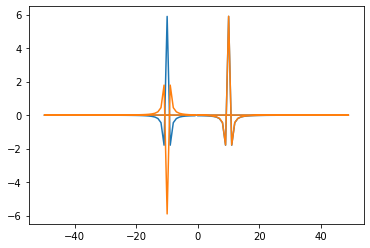

In [64]:
dt = 0.01
t_vals = np.arange(0, 1, dt)
freqs = np.fft.fftfreq(len(t_vals), dt)
sig = Signal(lambda t: t *(1-t), carrier_freq=10., phase=np.pi/4)
y_vals = np.fft.fft(sig(t_vals))
plt.plot(freqs, y_vals.real, freqs, y_vals.imag)

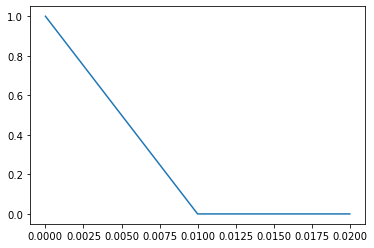

In [65]:
def decay(t):
    return np.exp(-10000 * t)

conv_kernel = decay(np.arange(0, 0.03, dt))
conv_kernel = conv_kernel / np.sum(conv_kernel)
plt.plot(np.arange(0, 0.03, dt), conv_kernel)

In [66]:
conv_kernel

array([1.00000000e+00, 3.72007598e-44, 1.38389653e-87])

In [67]:
print(len(np.convolve(sig(t_vals), gauss(t_vals))))

plt.plot(t_vals, np.convolve(conv_kernel, sig(t_vals))[0:len(t_vals)])
#plt.plot(np.arange(0-5*dt, 1. + 4*dt, dt), np.convolve(conv_kernel, sig(t_vals)))

NameError: name 'gauss' is not defined

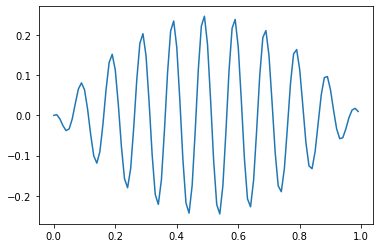

In [68]:
plt.plot(t_vals, np.convolve(conv_kernel, sig(t_vals))[0:len(t_vals)])

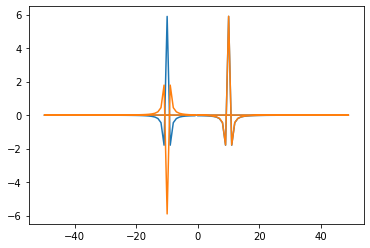

In [69]:
ft = np.fft.fft(np.convolve(conv_kernel, sig(t_vals))[0:len(t_vals)])
freqs = np.fft.fftfreq(t_vals.shape[0], dt)
plt.plot(freqs, ft.real, freqs, ft.imag)

In [70]:
positive_spec = 2*np.where(freqs >= 0, ft, np.zeros_like(ft))

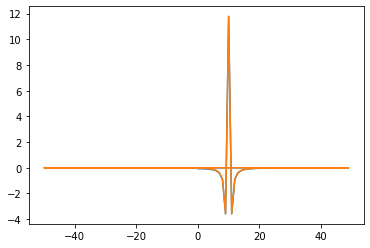

In [71]:
plt.plot(freqs, positive_spec.real, freqs, positive_spec.imag)

In [ ]:
undone = np.fft.ifft(positive_spec) * np.exp(-1j * 2 * np.pi * 10 * t_vals)
new_sig = PiecewiseConstant(dt=dt, samples=undone, carrier_freq=10.)
undone_vals = new_sig.envelope(t_vals)
plt.plot(t_vals, undone_vals.real, t_vals, undone_vals.imag)

In [ ]:
ft = np.fft.fft(undone_vals)
freqs = np.fft.fftfreq(t_vals.shape[0], dt)
plt.plot(freqs, ft.real, freqs, ft.imag)

f(np.array([1., 2.

In [ ]:
convolved[0:10]

In [ ]:
sig(t_vals)[0:10]

In [ ]:
np.dot(np.flip(conv_kernel), sig(t_vals)[-10:])

In [ ]:
np.convolve(conv_kernel, sig(t_vals))[-10]